## QModel

* by Ainur Kazykhanov

### Import libraries 

In [1]:
from __future__ import print_function
from sklearn.externals import joblib
import pandas as pd
import numpy as np
import os
import time
import warnings
warnings.filterwarnings('ignore')

### Import classes

In [2]:
from data_fn import Data
from alpha_fn import Alpha
from fit_fn import Fit
from simulation_fn import Simulation
from evaluation_fn import Evaluation

Using TensorFlow backend.


## Description

* Chosen strategy works with daily data and rebalance portfolio every day at market open.
* Model trains on historical data and returns predictions of every day close price.
* Core model consists of two neural networks working with different sets of targets aimed to predict single value and sequences.
* Final prediction is a linear combination of these two predictions.

## Assumptions

- The configuration for the model was found after a little trial and error and is by no means optimized! Calibrating the model parameters is a long journey. Anyway current set of parameters does not 'suffer' a lot from high bias / high variance.

## Config

* __options.ini__ file with all necessary parameters stored in 'data/' folder.
* __copy__ in 'data/config_copy/'.

## Data

__Brief description:__
* Pre-process given raw data and converts it to data object containing data matrices of following format (stocks * days).

__Prepare data:__
* Resample given data to 1-day format.
* Select only following stocks:
    * enough data for analysis.
    * maximum gap length is 1.
    * have information about corporate events.
    * company corporate events actual history do not include chosen events.
* Get EPS events.
* Get Dividend events.
* Get sector codes.
* Adjust data on stock splits and dividends.

In [3]:
# Convert raw data to required format.
# : input: given raw data.
# : return: -
# : store: save data object to disk.
Data().prepare_data()

Prepare data: 
  stocks: 662 (start)
  stocks: 447 (end)
data completed.


## Alpha

__Brief description:__
* Derive alphas from given data.

__Alphas list:__
1.  __A__: adv
2.  __A__: open p. momentum (1d)
3.  __A__: high p. momentum (1d)
4.  __A__: low p. momentum (1d)
5.  __A__: close p. momentum (1d)
6.  __A__: momentum (3d)
7.  __A__: momentum (10d)
8.  __A__: momentum (21d)
9.  __A__: momentum (70d)
10. __A__: momentum (130d)
11. __A__: sma (7d)
12. __A__: sma (21d)
13. __A__: macd
14. __A__: bollinger bands
15. __A__: standard deviation
16. __A__: information ratio
17. __A__: iqr
18. __A__: 10% percentile
19. __A__: 25% percentile
20. __A__: 75% percentile
21. __A__: 90% percentile
22. __A__: positive cross count
23. __A__: negative cross count
24. __A__: median return
25. __A__: mean return (3d)
26. __A__: mean return (5d)
27. __A__: mean return (10d)
28. __A__: mean return (21d)
29. __A__: mean reversion (3d)
30. __A__: mean reversion (5d)
31. __A__: mean reversion (10d)
32. __A__: mean reversion (21d)
33. __A__: dividends regular cash yield constant
34. __A__: dividends regular cash yield relative
35. __A__: dividends special cash yield constant
36. __A__: dividends special cash yield relative
37. __A__: eps earnings yield constant
38. __A__: eps earnings yield relative
39. __A__: eps earnings-estimate yield constant
40. __A__: eps earnings-estimate yield relative
41. __A__: eps earnings-comparable yield constant
42. __A__: eps earnings-comparable yield relative
43. __E__: dividends regular
44. __E__: dividends special
45. __E__: eps earnings
46. __E__: eps comparable
47. __E__: eps estimate
48. __T__: original data
49. __T__: wavelet transform

__WARNING!__ 
__It takes a lot of time.__

In [ ]:
# Create alphas.
# : input: data object.
# : return: -
# : store: save alphas to disk.
Alpha().run_alphas()

## Fit

__Brief description:__
* Train the model on given set of alphas-labels and return predictions on each day.

__Prepare data:__
- Feature Eng: 
    - d-SAE model extracts high level deep features from given alpha matrix.
- Feature selection: 
    - gBoosting based feature importance filter drops irrelevant features.
- Stacking (alpha): 
    - add events to alpha matrix.
- Stacking (alpha): 
    - bayesian ridge model predicts target values and stack predictions to alpha matrix. 
- Stacking (target): 
    - add two more days to target matrix (original).
- Stacking (target): 
    - add total return (3 days) to target values (original).

__Model:__
* __ALPHA:__ 
    * 2-rRNet w/ DeepConv features in pair with Seq2Seq DeepConv-GRU predict '3 day+total' and '3 day' returns.  
* __BETA:__ 
    * 2-rRNet in pair with Feature Pyramid Network predict '1 day' return.  

__Prediction:__
* Predictions are made using MC Dropout sampling and weighting sequence predictions together with single day forecasts.

__Details__:
- First training (general): 
    - general + fine tuning of all layers. 
- Transfer learning (if activated): 
    - transfer learning with newly initialized last layers + fine tuning of all layers + freezing.
    - model freeze selected layers for a certain period of time specified in options.ini, after a given period layers become trainable again.

__WARNING!__
__It takes a lot of time.__

In [ ]:
# Fit the model.
# : input: data object and alphas.
# : return: predicted positions matrix
# : store: save predictions to disk.
positions_strategy = Fit().run_model()

## Simulation

__Brief description:__
* PnL modeling on day to day basis.

__Prepare data:__
* Balancing long-short positions.
* Slowing down trading applying basic smoothing.
* Industry neutralization.
* Selecting N best stocks in both directions.

__Details:__
* Commissions: Interactive Brokers.
* Price Slippage: None

__Assumptions:__
* No borrowing costs.
* No cash borrowing for long positions.
* Immediate trade settlement.

In [3]:
# Load positions matrix.
positions_strategy = joblib.load('data/pp_data/positions/positions.pickle')

In [ ]:
# Run simulation
# : input: predicted positions matrix
# : return: sim object
# : store: -
strategy = Simulation(positions_strategy).run_simulation()

## Evaluation

__Brief description:__
* Show results and basic performance metrics compared to SP500.


Evaluation started:
  report saved
  evaluation completed


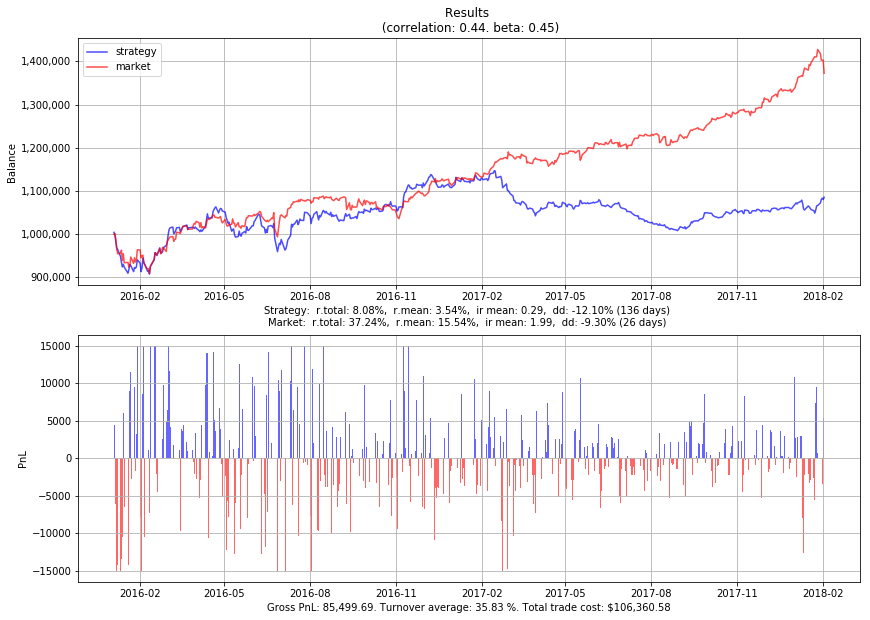

In [5]:
# Show strategy performance.
# : input: sim object.
# : return: plot results
# : store: save report.xlsx (data/pp_data/sim_res/)
Evaluation(strategy).run_evaluation(save_report=True)